Blog bost at: http://kldavenport.com/pure-python-decision-trees/

###Our Data:

First let's define our data, in this case a list of lists. Let's imagine that this data is for a SaaS product we are selling. We offer users a trial 14-days and at the end of the trial offer the users the ability to sign up for a basic or premium offering. We collect the following info from them from beginning to end:

1. Where the customer was referred from when they signed up for the trial (google, slashdot, etc.) [Domain name string or (direct)]
2. Country of orgin (resolved by IP) [Country string]
3. Clicked on our FAQ link during the trail? [boolean]
4. How many application pages they viewed during the trial. [int]
5. What service they choose at the end of the trial. [None, Basic, Premium strings]

In [1]:
my_data=[['slashdot','USA','yes',18,'None'],
        ['google','France','yes',23,'Premium'],
        ['reddit','USA','yes',24,'Basic'],
        ['kiwitobes','France','yes',23,'Basic'],
        ['google','UK','no',21,'Premium'],
        ['(direct)','New Zealand','no',12,'None'],
        ['(direct)','UK','no',21,'Basic'],
        ['google','USA','no',24,'Premium'],
        ['slashdot','France','yes',19,'None'],
        ['reddit','USA','no',18,'None'],
        ['google','UK','no',18,'None'],
        ['kiwitobes','UK','no',19,'None'],
        ['reddit','New Zealand','yes',12,'Basic'],
        ['slashdot','UK','no',21,'None'],
        ['google','UK','yes',18,'Basic'],
        ['kiwitobes','France','yes',19,'Basic']]

### Creating our tree
Below we define a class to represent each node a tree.

Note: I'm not assuming a certain python level for this blog post, as such I will go over some programming fundamentals. A class is a user-defined prototype (guide, template, etc.) for an object that defines a set of attributes that characterize any object of the class. The attributes are data members (class variables and instance variables) and methods, accessed via dot notation. If you've been using something like scikit-learn up to this point I'm sure you're used to model.fit(), model.score(), etc. Fit and score are all instance methods of whatever model you've instantiated. For example:

```python
clf = linear_model.SGDRegressor() # Instantiating SGDRegressor as clf 
clf.fit(X, y) # using clf's (an instance of SGDRegressor) fit method on some data
```

In [2]:
class decisionnode:
    def __init__(self,col=-1,value=None,results=None,tb=None,fb=None):
        self.col=col # column index of criteria being tested
        self.value=value # vlaue necessary to get a true result
        self.results=results # dict of results for a branch, None for everything except endpoints
        self.tb=tb # true decision nodes 
        self.fb=fb # false decision nodes

Now let's work on the intelligence behind contructing the tree. One of the more popular methods for consructing trees, CART (Classification And Regression Trees), was developed by Leo Breiman https://www.stat.berkeley.edu/~breiman/papers.html. CART is a recursive partitioning method that builds classification and regression trees for predicting continuous and categorical variables.

The first step is to construct a root node by considering all the observations in our dataset and determine which variable or feature would subset the data the most. If we were looking at a lung cancer outcomes dataset for example and one of the variables was smoker (y/n), it would be intuitive that this would split the dataset up substantially.



In [3]:
# Divides a set on a specific column. Can handle numeric or nominal values

def divideset(rows,column,value):
    # Make a function that tells us if a row is in the first group 
    # (true) or the second group (false)
    split_function=None
    # for numerical values
    if isinstance(value,int) or isinstance(value,float):
        split_function=lambda row:row[column]>=value
    # for nominal values
    else:
        split_function=lambda row:row[column]==value
   
   # Divide the rows into two sets and return them
    set1=[row for row in rows if split_function(row)] # if split_function(row) 
    set2=[row for row in rows if not split_function(row)]
    return (set1,set2)

Using the previously defined `my_data` let's split our data by users in the USA.

In [4]:
divideset(my_data,1,'USA')

([['slashdot', 'USA', 'yes', 18, 'None'],
  ['reddit', 'USA', 'yes', 24, 'Basic'],
  ['google', 'USA', 'no', 24, 'Premium'],
  ['reddit', 'USA', 'no', 18, 'None']],
 [['google', 'France', 'yes', 23, 'Premium'],
  ['kiwitobes', 'France', 'yes', 23, 'Basic'],
  ['google', 'UK', 'no', 21, 'Premium'],
  ['(direct)', 'New Zealand', 'no', 12, 'None'],
  ['(direct)', 'UK', 'no', 21, 'Basic'],
  ['slashdot', 'France', 'yes', 19, 'None'],
  ['google', 'UK', 'no', 18, 'None'],
  ['kiwitobes', 'UK', 'no', 19, 'None'],
  ['reddit', 'New Zealand', 'yes', 12, 'Basic'],
  ['slashdot', 'UK', 'no', 21, 'None'],
  ['google', 'UK', 'yes', 18, 'Basic'],
  ['kiwitobes', 'France', 'yes', 19, 'Basic']])

Granted this is a small samples of data, country of orgin doesn't seem to be a good variable to split on at this point as we still have a good representation/mix of subscription outcomes in both sets above (None, Basic, Premium).

We need a formalized manner to assess how mixed a result set is in order to properly check the outcome of spliting on each variable. When constructing our root node we should chose a variable that creates two sets with the least possible amount of mixing. To start let's create a function to count the occurences of the outcomes in each set. We'll use this function later on inside other functions to measure how mixed a set is.

In [5]:
# Create counts of possible results (last column of each row is the result)
def uniquecounts(rows):
    results={}
    for row in rows:
        # The result is the last column
        r=row[len(row)-1]
        if r not in results: results[r]=0
        results[r]+=1
    return results

Sorry I couldn't help but look for an excuse to use `defaultdict` from `collections`!

In [6]:
from collections import defaultdict
def uniquecounts_dd(rows):
    results = defaultdict(lambda: 0)
    for row in rows:
        r = row[len(row)-1]
        results[r]+=1
    return dict(results) 

In [7]:
uniquecounts(my_data),'Same output', uniquecounts_dd(my_data)

({'Basic': 6, 'None': 7, 'Premium': 3},
 'Same output',
 {'Basic': 6, 'None': 7, 'Premium': 3})

###Measures of mixture

In a previous post I took an in-depth look at Entropy or the measure of surprisal: http://kldavenport.com/a-real-world-introduction-to-information-entropy/ I'll cover the basics here, but please refer to my other post for more detail. At least watch this creative video on information entropy:

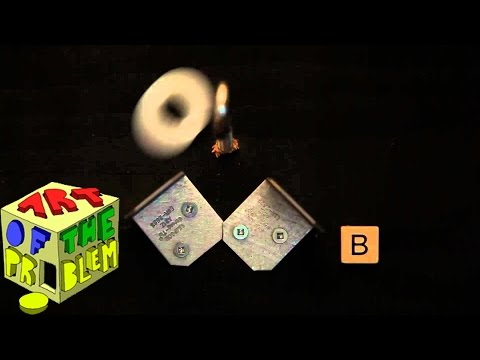

In [8]:
from IPython.display import YouTubeVideo
YouTubeVideo('R4OlXb9aTvQ')

Our entropy function will calculate how many times a class appears and divide it by the number of observations in our data set:

$$ p(i) = frequency(outcome) = count(outcome) \thinspace/ \thinspace count(total rows) $$

It then does the following for all outcomes, $p(i)$:

$$ Entropy = sum \thinspace of \thinspace p(i) * log(p(i)) $$




In [9]:
# Entropy is the sum of p(x)log(p(x)) across all the different possible results
def entropy(rows):
    from math import log
    log2=lambda x:log(x)/log(2)  
    results=uniquecounts(rows)
    # Now calculate the entropy
    ent=0.0
    for r in results.keys():
        # current probability of class
        p=float(results[r])/len(rows) 
        ent=ent-p*log2(p)
    return ent

In [10]:
entropy(my_data)

1.5052408149441479

Essentially entropy is higher the more mixed up the groups or outcomes of subscription is. Trying the function on a data set where the outcomes either `None` or `Basic` should result in a smaller number:

In [11]:
my_data2=[['slashdot','USA','yes',18,'None'],
        ['google','France','yes',23,'None'],
        ['reddit','USA','yes',24,'Basic'],
        ['kiwitobes','France','yes',23,'Basic'],
        ['google','UK','no',21,'None'],
        ['(direct)','New Zealand','no',12,'None'],
        ['(direct)','UK','no',21,'Basic']]

entropy(my_data2)

0.9852281360342516

We now have a method of assessing entropy. The next step in building our tree will involve assessing the success of each variable's ability to split the dataset. In other words we're attempting to identify the feature that best splits the target class into the purest children nodes. These pure nodes would not contain a mix of output classes, in this case subscription level (None, Basic, Premium).

We'll start by calculating the entropy of the entire data set then dividing the group by all the possible outcomes for each attribute. We determine the best attribute to divide on by calculating information gain (Entropy before - Entropy after). Again more info in my more detailed post on entropy here: http://kldavenport.com/a-real-world-introduction-to-information-entropy/

**Caveats:**
Information gain is generally a good measure for deciding the relevance of an attribute, but there are some distinct shortcomings. One case is when information gain is applied to variabless that take on a large number of unique values. This is a concern not necessarily from a pure variance perspective, rather that the variable is too descriptive of the current observations.

**High mutual information** indicates a large reduction in uncertainty, credit card numbers or street addresss variables in a dataset uniquely identify a customer. These variables provide a great deal of identifying information if we are trying to predict a customer, but will not generalize well to unobserved/trained-on instances (overfitting).

In [12]:
def buildtree(rows, scorefun=entropy):
    if len(rows) == 0: return decisionnode()
    current_score = scorefun(rows)

    best_gain = 0.0
    best_criteria = None
    best_sets = None

    column_count = len(rows[0]) - 1	# last column is result
    for col in range(0, column_count):
        # find different values in this column
        column_values = set([row[col] for row in rows])

        # for each possible value, try to divide on that value
        for value in column_values:
            set1, set2 = divideset(rows, col, value)

            # Information gain
            p = float(len(set1)) / len(rows)
            gain = current_score - p*scorefun(set1) - (1-p)*scorefun(set2)
            if gain > best_gain and len(set1) > 0 and len(set2) > 0:
                best_gain = gain
                best_criteria = (col, value)
                best_sets = (set1, set2)

    if best_gain > 0:
        trueBranch = buildtree(best_sets[0])
        falseBranch = buildtree(best_sets[1])
        return decisionnode(col=best_criteria[0], value=best_criteria[1],
                tb=trueBranch, fb=falseBranch)
    else:
        return decisionnode(results=uniquecounts(rows))

We now have a function that returns a trained decision tree. We can print a rudimentary tree.

In [14]:
def printtree(tree,indent=''):
    # Is this a leaf node?
    if tree.results!=None:
        print(str(tree.results))
    else:
        # Print the criteria
        print 'Column ' + str(tree.col)+' : '+str(tree.value)+'? '

        # Print the branches
        print indent+'True->',
        printtree(tree.tb,indent+'  ')
        print indent+'False->',
        printtree(tree.fb,indent+'  ')

SyntaxError: invalid syntax (<ipython-input-14-2dac3c387be3>, line 4)

In [ ]:
# Printing a few rows of our dataset for context
my_data[0:3]

When printing the tree we see that the root node checks if column 0 contains 'google'. If the condition is met (condition is True) we then move on to see that anyone that was referred from Google will purchase a subscription (Basic or Premium) if they view 21 pages or more and so on.

In [ ]:
printtree(buildtree(my_data))

The next step might be to classify new observations by building a function that traverses the tree. We could even make our implementation more advanced by implementing pruning: https://en.wikipedia.org/wiki/Pruning_(decision_trees). If you're interested in pure python implementations of analytics implementations check out the aforementioned book by Toby Segaran [Programming Collective Intelligence](http://www.amazon.com/Programming-Collective-Intelligence-Building-Applications/dp/0596529325)